In [1]:
from gabriel_lego import LEGOTask
from tqdm.notebook import tqdm

import edgedroid.data as e_data
from edgedroid.models import *
from generate_corr_sequence import gen_corr_sequence
import scipy.stats as st

model = EdgeDroidModel(
    frame_trace=e_data.load_default_trace("square00", truncate=5),
    frame_model=ZeroWaitSamplingPolicy.from_default_data(),
    timing_model=MultiCurveFittingExecutionTimeModel(neuroticism=1.0)
)

task = LEGOTask(e_data.load_default_task("square00", truncate=5))


acf_50 = 1 / (2 ** np.arange(5))  # 0.5 corr
acf_25 = 1 / (4 ** np.arange(5))
acf_12 = 1 / (8 ** np.arange(5))
acf_00 = np.zeros(5)
acf_00[0] = 1.0

num_frames_to_generate = 7200 * 30  # assume task takes 2hrs at 30fps 


def emulate_run(model: EdgeDroidModel, rtt_s_iter: Iterator[float]):
    for model_step in model.play_steps_emulated_time():
        # in this setup, we have rtts per frame
        frame_timings: Optional[FrameTimings] = None
        prev_frame: Optional[str] = None
        while True:
            try:
                model_frame = model_step.send(frame_timings)
            except StopIteration:
                if not prev_frame or prev_frame.lower() not in ("success", "initial"):
                    raise Exception(prev_frame)
                break

            # prev_result = task.submit_frame(model_frame.frame_data)
            prev_frame = model_frame.frame_tag
            frame_rtt = next(rtt_s_iter)
            frame_timings = FrameTimings(frame_rtt * 0.9, frame_rtt * 0.1)

delays  = gen_corr_sequence(
    dist_obj=st.lognorm(s=1.2, loc=0.1, scale=0.1),
    L=num_frames_to_generate,
    target_acf=acf_50,
    debug=False,
)

emulate_run(model, iter(delays))
model.model_step_metrics()

,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count
step_number,,,,,,
0,0.219072,0.000000,0.219072,0.219072,0.000000,1
1,0.120089,5.033510,5.340434,0.306924,0.186835,20
2,0.581823,5.064794,5.751893,0.687099,0.105276,18
3,0.255850,5.173617,6.061119,0.887501,0.631651,21
4,0.153875,4.890448,5.138104,0.247656,0.093781,26
5,0.124392,5.043972,5.286173,0.242202,0.117810,28


In [2]:
import itertools as it
import multiprocess as mp

trace = "square00"
truncate = 50
reps_per_model = 30
rep_offset = 0

s_param = 1.2


class ThirdDegPolyExecutionTimeModel(MultiCurveFittingExecutionTimeModel):
    _fit_functions = (CubeFit,)


timing_frame_models = {
    "3rd-poly-high": lambda: (ThirdDegPolyExecutionTimeModel(neuroticism=1.0), ZeroWaitSamplingPolicy.from_default_data()),
    "3rd-poly-low": lambda:(ThirdDegPolyExecutionTimeModel(neuroticism=0.0), ZeroWaitSamplingPolicy.from_default_data()),
    "legacy": lambda: (LegacyModel(), LegacySamplingPolicy.from_default_data()),
    "first-order": lambda: (FirstOrderETM(), ZeroWaitSamplingPolicy.from_default_data()),
    "first-order-median": lambda: (FirstOrderAggregateETM(np.median), ZeroWaitSamplingPolicy.from_default_data())
}

min_bound = 0.042  # 24FPS

rhos = (
    (0.0, acf_00),
    # (0.125, acf_12),
    # (0.250, acf_25),
    # (0.500, acf_50),
)

scales = (
    0.1,
    0.2,
    0.4,
    0.8,
    1.6,
    3.2,
)

def run_model(params):
    rep, (rho, acf_fn), scale, (model_name, model_constructor) = params
    timing_model, sampling_policy = model_constructor()

    model = EdgeDroidModel(
        frame_trace=e_data.load_default_trace(trace, truncate=truncate),
        frame_model=sampling_policy,
        timing_model=timing_model
    )

    delays = gen_corr_sequence(
        dist_obj=st.lognorm(s=s_param, loc=min_bound, scale=scale),
        L=num_frames_to_generate,
        target_acf=acf_fn,
        debug=False,
    )

    emulate_run(model, iter(delays))

    df = model.model_step_metrics()
    df["model"] = model_name
    df["rep"] = rep
    df["s_param"] = s_param
    df["rho"] = rho
    df["scale"] = scale
    
    return df

params_iter = list(it.product(
    range(rep_offset, reps_per_model + rep_offset), 
    rhos, 
    scales,
    timing_frame_models.items(),
))
tqdm_iter = iter(tqdm(params_iter, desc="Running models"))

dfs = deque()

with mp.Pool() as pool:
    for df in pool.imap_unordered(run_model, params_iter): 
        dfs.append(df)
        next(tqdm_iter)

data = pd.concat(dfs)
data.to_csv("./per_frame_delay_fixed_acf00.csv")
data

Running models:   0%|          | 0/900 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
data = pd.concat((pd.read_csv("per_frame_delay_fixed.csv"), pd.read_csv("per_frame_delay_fixed_acf00.csv")))
models = pd.CategoricalDtype(["3rd-poly-low", "3rd-poly-high", "legacy", "first-order", "first-order-median"],
                             ordered=False)
data["model"] = data["model"].astype(models)
# data = data[data["rho"] < 0.8]
# data = data[data["sigma"] < 3.2]

rho_scale_dtype = pd.CategoricalDtype(
    map(lambda t: f"{t[0]} {t[1]}", itertools.product(sorted(data["rho"].unique()), sorted(data["scale"].unique()))),
    ordered=True)

data["rho"] = data["rho"].astype("category")
data["scale"] = data["scale"].astype("category")

data["rho_scale"] = data[["rho", "scale"]].apply(func=lambda row: f"{row.rho} {row.scale}", axis=1).astype(
    rho_scale_dtype)
data

data.groupby(["model", "rep", "rho", "scale", "rho_scale"], observed=True).count()

step_number  last_frame_rtt  \
model              rep rho scale rho_scale                                
3rd-poly-low       0   0.0 0.05  0.0 0.05           102             102   
                           0.10  0.0 0.1            102             102   
                           0.20  0.0 0.2            102             102   
                           0.40  0.0 0.4            102             102   
                           0.80  0.0 0.8            102             102   
...                                                 ...             ...   
first-order-median 29  0.5 0.20  0.5 0.2             51              51   
                           0.40  0.5 0.4             51              51   
                           0.80  0.5 0.8             51              51   
                           1.60  0.5 1.6             51              51   
                           3.20  0.5 3.2             51              51   

                                            execution_time  step_duration  \
model              rep rho scale rho_scale                                  
3rd-poly-low       0   0.0 0.05  0.0 0.05              102            102   
                           0.10  0.0 0.1               102            102   
                           0.20  0.0 0.2               102            102   
                           0.40  0.0 0.4               102            102   
                           0.80  0.0 0.8               102            102   
...                                                    ...            ...   
first-order-median 29  0.5 0.20  0.5 0.2                51             51   
                           0.40  0.5 0.4                51             51   
                           0.80  0.5 0.8                51             51   
                           1.60  0.5 1.6                51             51   
                           3.20  0.5 3.2                51             51   

                                            time_to_feedback  wait_time  \
model              rep rho scale rho_scale                                
3rd-poly-low       0   0.0 0.05  0.0 0.05                102        102   
                           0.10  0.0 0.1                 102        102   
                           0.20  0.0 0.2                 102        102   
                           0.40  0.0 0.4                 102        102   
                           0.80  0.0 0.8                 102        102   
...                                                      ...        ...   
first-order-median 29  0.5 0.20  0.5 0.2                  51         51   
                           0.40  0.5 0.4                  51         51   
                           0.80  0.5 0.8                  51         51   
                           1.60  0.5 1.6                  51         51   
                           3.20  0.5 3.2                  51         51   

                                            frame_count  s_param  
model              rep rho scale rho_scale                        
3rd-poly-low       0   0.0 0.05  0.0 0.05           102      102  
                           0.10  0.0 0.1            102      102  
                           0.20  0.0 0.2            102      102  
                           0.40  0.0 0.4            102      102  
                           0.80  0.0 0.8            102      102  
...                                                 ...      ...  
first-order-median 29  0.5 0.20  0.5 0.2             51       51  
                           0.40  0.5 0.4             51       51  
                           0.80  0.5 0.8             51       51  
                           1.60  0.5 1.6             51       51  
                           3.20  0.5 3.2             51       51  

[4200 rows x 8 columns]

In [4]:
total_durations = data.groupby(["model", "rep", "rho", "scale", "rho_scale"], observed=True)[
    "step_duration"].sum().reset_index()
total_durations

,model,rep,rho,scale,rho_scale,step_duration
0,3rd-poly-low,0,0.0,0.05,0.0 0.05,509.427637
1,3rd-poly-low,0,0.0,0.10,0.0 0.1,557.864492
2,3rd-poly-low,0,0.0,0.20,0.0 0.2,617.477931
3,3rd-poly-low,0,0.0,0.40,0.0 0.4,792.233956
4,3rd-poly-low,0,0.0,0.80,0.0 0.8,940.277915
...,...,...,...,...,...,...
4195,first-order-median,29,0.5,0.20,0.5 0.2,337.335964
4196,first-order-median,29,0.5,0.40,0.5 0.4,432.791807
4197,first-order-median,29,0.5,0.80,0.5 0.8,489.427648
4198,first-order-median,29,0.5,1.60,0.5 1.6,785.419556


mean duration


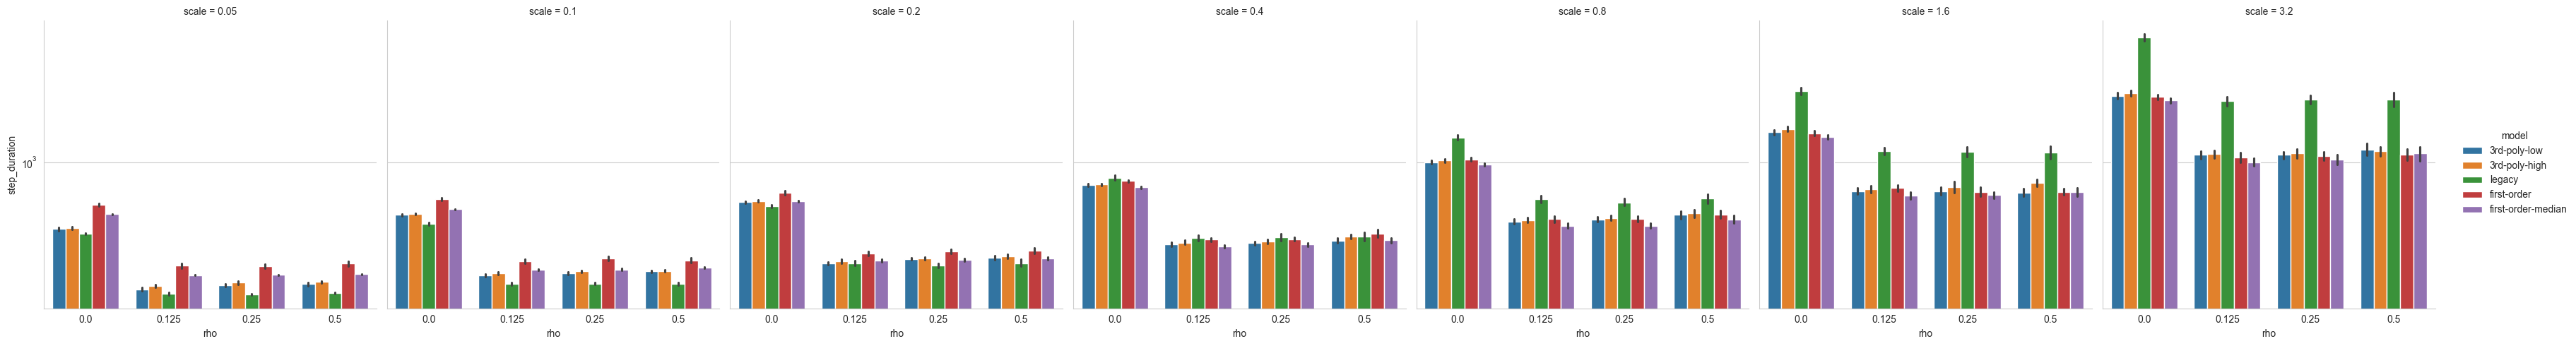

In [5]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

print("mean duration")
fg = sns.catplot(kind="bar", data=total_durations, hue="model", y="step_duration", col="scale", x="rho")
fg.set(yscale="log")
plt.show()

# push correlation higher

mean number of frames


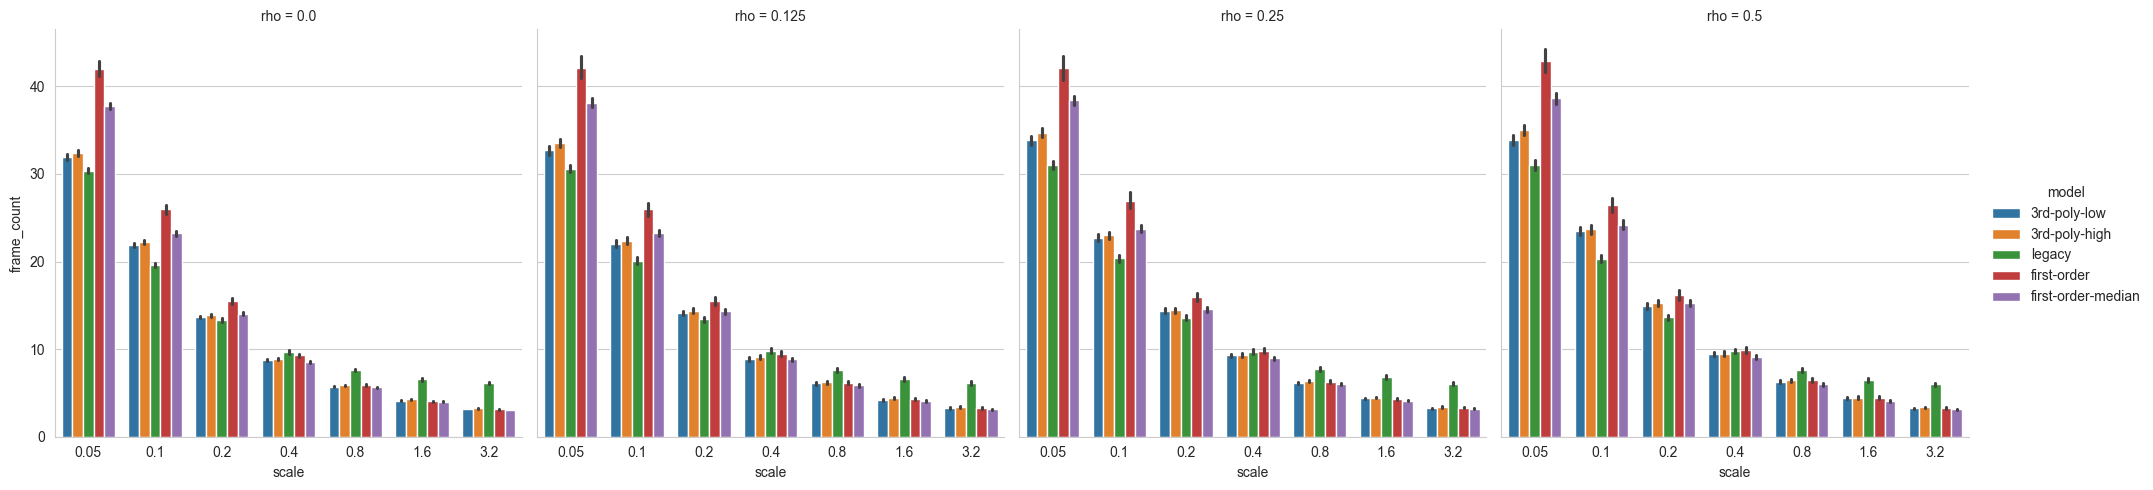

In [6]:
print("mean number of frames")
fg = sns.catplot(kind="bar", data=data, y="frame_count", hue="model", x="scale", col="rho")
plt.show()

mean TTF


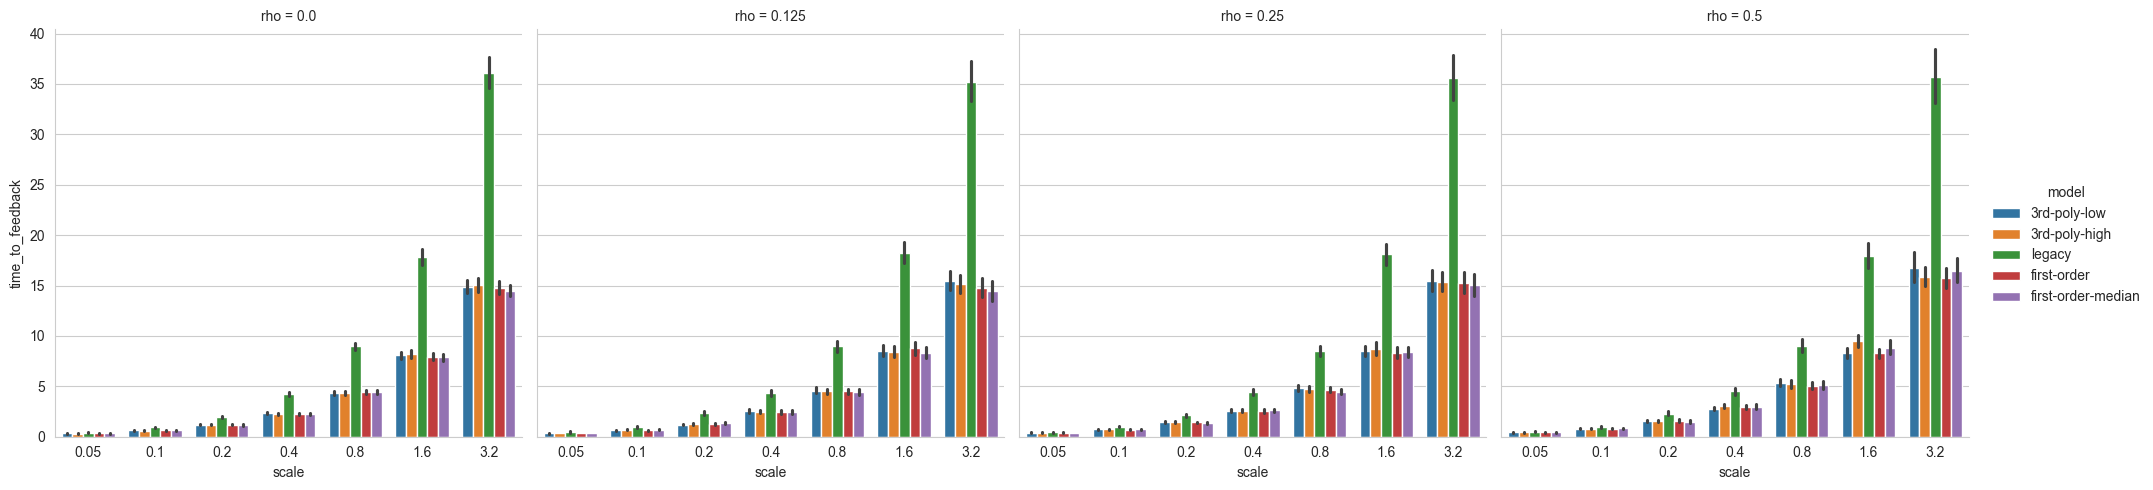

In [7]:
print("mean TTF")
fg = sns.catplot(kind="bar", data=data, hue="model", y="time_to_feedback", x="scale", col="rho")
plt.show()

mean wait time


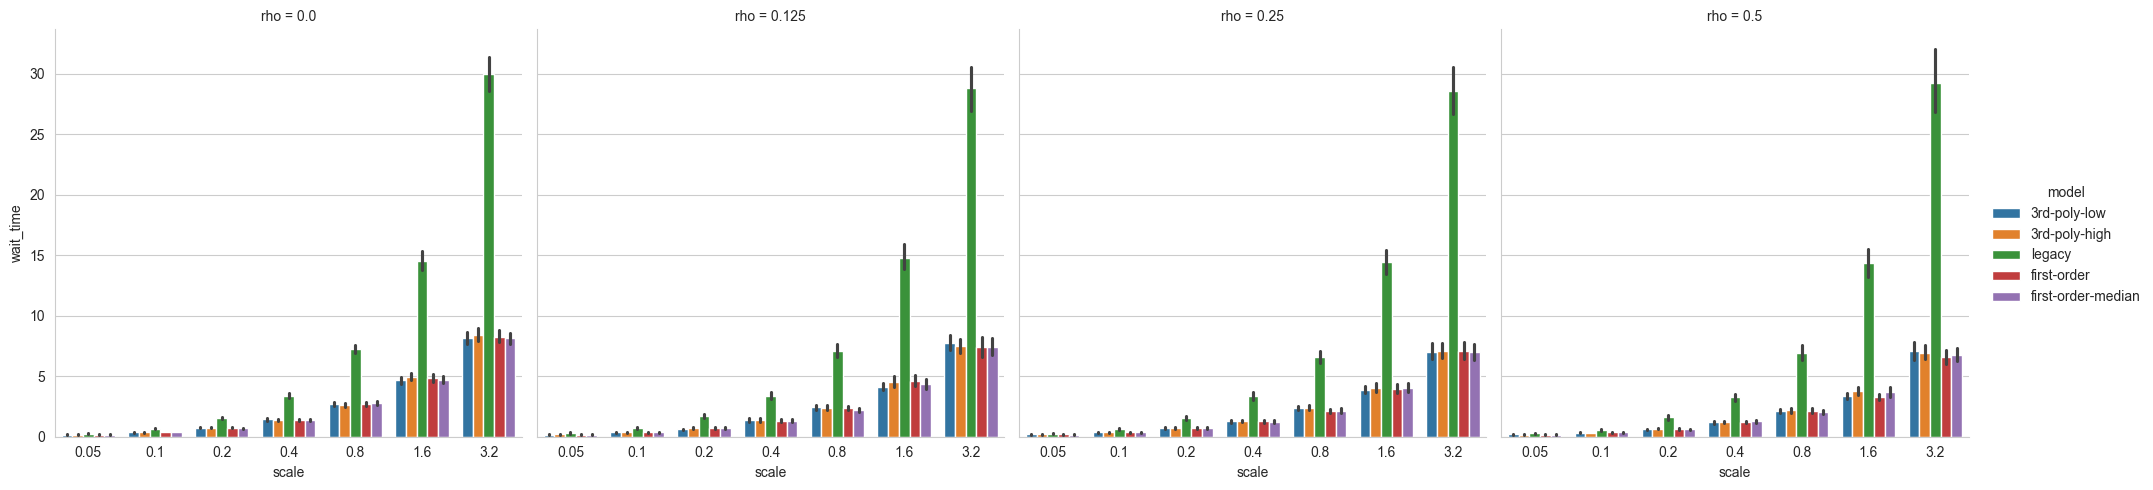

In [8]:
print("mean wait time")
fg = sns.catplot(kind="bar", data=data, hue="model", y="wait_time", x="scale", col="rho")
plt.show()

mean last frame rtt


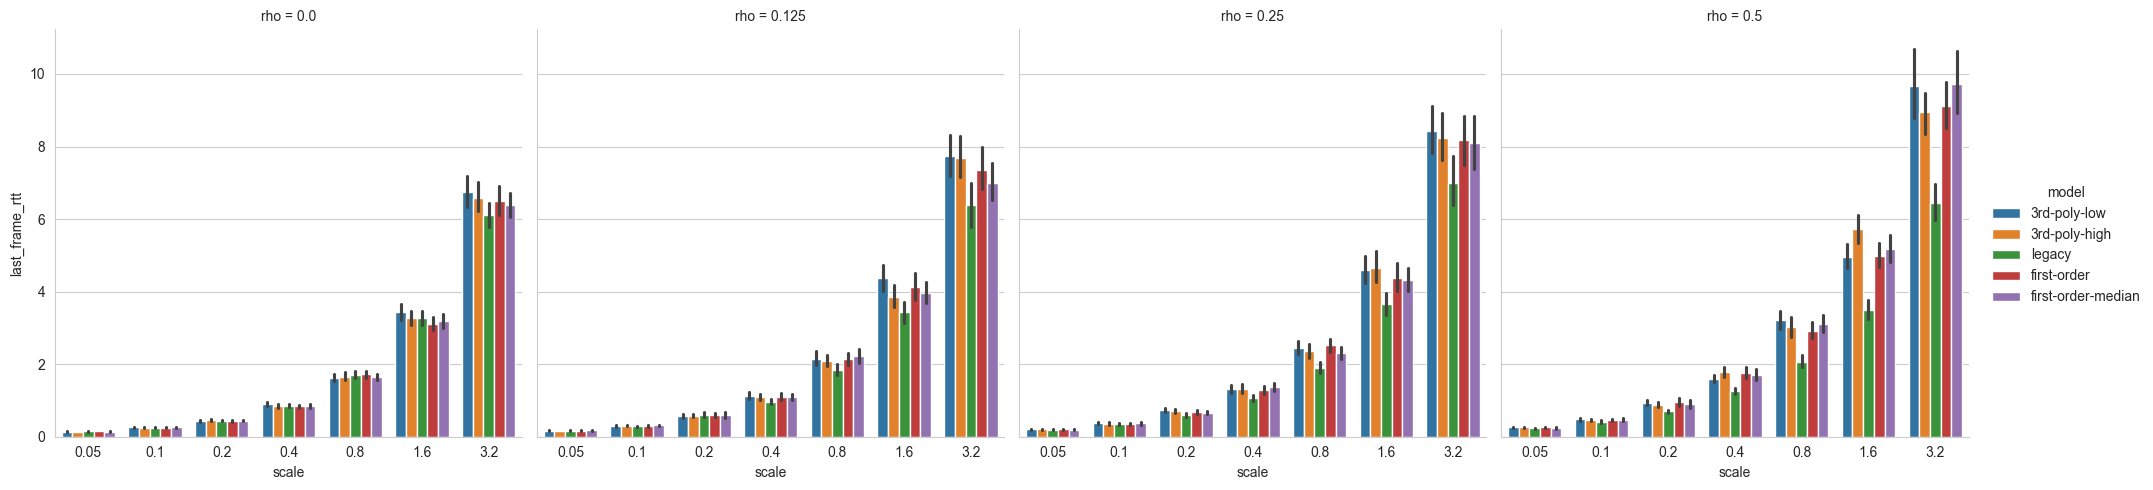

In [9]:
print("mean last frame rtt")
fg = sns.catplot(kind="bar", data=data, hue="model", y="last_frame_rtt", x="scale", col="rho")
plt.show()